You can follow along and play with this notebook by clicking the badge below

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/COGS118A/demo_notebooks/blob/main/lecture_11_cross_validation.ipynb)

# Cross validation

Previously, we saw the basic recipe for applying a supervised machine learning model:

1. Choose a feature representation of the data
1. Choose a class of algorithm/model
1. Split the data into training set and test set
1. Fit the model to the training data
1. Use the model to predict labels for test set
1. Use those predictions and the true labels to make a metric measuring model performance

It turns out that there are more ways than just train/test split. Cross validation is often used to make a better estimate of performance, especailly when you don't have an enormous data set

Even more, I want to prime you for the idea that cross validation (or train-validate-test splitting) can be used for model selection.  We use validation sets to figure out which model is the best model out of several choices, before we use the test set to get an idea of what the perfromance level of the best model is.  But that will come next lecture... in the meantime


notes
- cross validation
  - sklearn helps take raw data and transofrm into features in one step
  - pipeline, ways to make sequence of estimators 
    - separate stages of pipeline w , 
- arguments of linear regression , one hot transform categories



In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="white") # plot formatting
%config InlineBackend.figure_format ='retina'

# toy data ~ randomly sampled underlying asymptotic function + gaussian noise 
def true_func(X):
  return 10 - 1. / (X.ravel() + 0.1)

def make_data(N, err=1.0, rseed=1):
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = true_func(X)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

Let's introduce you to a _pipeline_, a scikit-learn method to put together a bunch of functions into a single learning algorithm. You can see the documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

Remember our old way of doing the Polynomial Regression with OLS? We had to do each step explicitly:

```python
feature = PolynomialFeatures(degree=9)
X_train = feature.fit_transform(x_train)
X_predict = feature.fit_transform(x_predict)
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)
y_predict = model.predict(X_predict)
```

The pipeline below allows us to construct it in a single call. 

```python
model = PolynomialRegression(degree=9, fit_intercept=False).fit(x_train, y_train)
y_predict = model.predict(x_predict)
```
Making a complicated algo into a single function is very helpful in scikit-learn.  It allows us to take advantage of handy scikit-learn methods that take a single argument, like cross-validation & learning curves.  Without this utility we would have to code a custom cross-validation loop for every single crazy algo we thought up.


In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# **kwargs allows you to pass through keyword arguments from our object
# down to the LinearRegression object
# the arg degree=2 is a default value; if you override it you get what you want
# but if you call PolynomialRegression() with no args, you get a quadratic regression
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

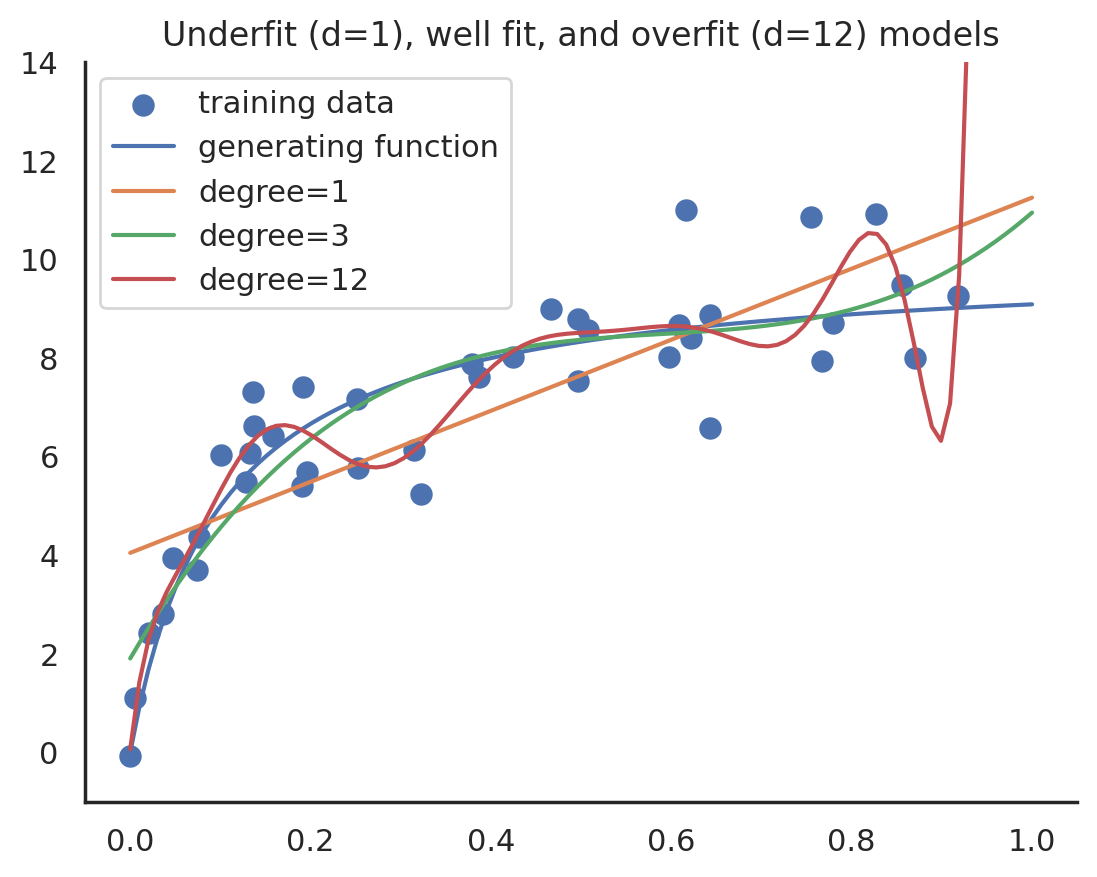

In [7]:
X, y = make_data(40,rseed=1234)

x_true = np.linspace(0, 1, 100).reshape(-1, 1) #  some x-vals so we can generate true y-vals
y_true = true_func(x_true)

plt.scatter(X, y, s=50, label="training data")
plt.plot(x_true, y_true, label="generating function")

for degree in [1, 3, 12]:
    y_predict = PolynomialRegression(degree,fit_intercept=False).fit(X, y).predict(x_true)
    plt.plot(x_true.ravel(), y_predict, label='degree={0}'.format(degree))

plt.ylim(-1, 14)
plt.legend()
plt.title('Underfit (d=1), well fit, and overfit (d=12) models');
sns.despine()

For cross validation a handy function called KFold() produces iterative splits of the data according to your needs...



In [8]:
# break the dataset up into 4 non-overlapping subsets. 
# Then we will do 4 times
#    Train on 3/4 of the data, Get a metric by predicting on the held out 1/4
#.   Each time we will use a different one of the 4 subsets as the hold out set
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

k_fold = KFold(n_splits=4)
model = PolynomialRegression(3,fit_intercept=False)

# collect the predicted y values and true y values of each hold out set
predicteds=[]
trueys=[]
for train, holdout in k_fold.split(X, y):
    model.fit(X[train],y[train])
    predicteds.append( model.predict(X[holdout]) )
    trueys.append( y[holdout] )

# this is because we ended up with a list of arrays
predicteds = np.array(predicteds)
trueys = np.array(trueys)

print('Validation error (MSE) across all 4 folds', mean_squared_error(trueys.flatten(),predicteds.flatten()) )

print('Validation error (MSE) in each of the 4 folds seperately')
for p, t in zip(predicteds,trueys):
    print(mean_squared_error(t,p))


Validation error (MSE) across all 4 folds 1.5684553626396909
Validation error (MSE) in each of the 4 folds seperately
1.4614637818897716
1.1768753454299792
1.8609787327931215
1.7745035904458912


In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

k_fold = KFold(n_splits=20)
model = PolynomialRegression(3,fit_intercept=False)

# collect the predicted y values and true y values of each hold out set
predicteds=[]
trueys=[]
for train, holdout in k_fold.split(X, y):
    model.fit(X[train],y[train])
    predicteds.append( model.predict(X[holdout]) )
    trueys.append( y[holdout] )

# this is because we ended up with a list of arrays
predicteds = np.array(predicteds)
trueys = np.array(trueys)

print('Validation error (MSE) across all 20 folds', mean_squared_error(trueys.flatten(),predicteds.flatten()) )


Validation error (MSE) across all 20 folds 1.5299438419018632


Why is the estimate for 20-fold cross-validation (train on 38 datapoints, test on 2) a bit lower than the MSE for 4-fold cross-validation (train on 30 data points, test on 10)?

It turns out the using less of the data for training induces a bias in 5-fold that tends to OVERESTIMATE the true error.  That is... less training data = worse model fit = worse test error

So does that mean we should dial the k in k-folds up high?

Not necessarily.

Because if we make the k very high (for instance, k=the number of data points is leave one out cross validation) then every single fold is getting almost excactly the same kind of training experience.  Now the estimates are unbiased in respect to estimating the sample (as we said above), but they are therefore highly variable with respect to the exact noise in the training set... draw a different training set from the underlying population and a LOOCV will have more variability of fit than the 3-fold cv.  



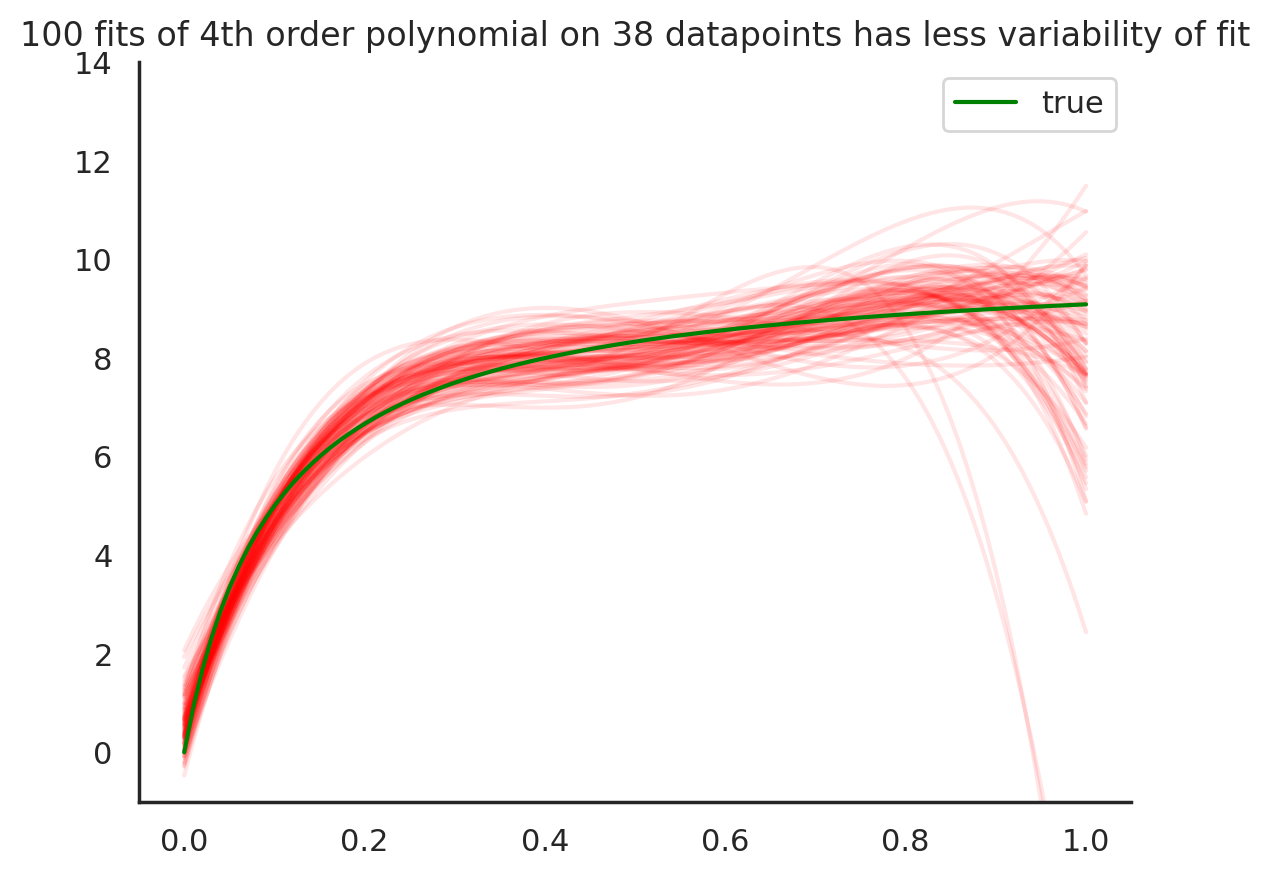

In [10]:
# draw 3800 data points from the same process
# split them up into 100 random subsets of 38 each
# fit a line on each of those subsets
# plot each of those lines

X, y = make_data(3800)
splitter = KFold(n_splits=100)
degree = 4

x_true = np.linspace(0, 1, 100).reshape(-1, 1) #  some x-vals so we can generate true y-vals
y_true = true_func(x_true)

for _, subset in splitter.split(X,y):
    y_predict = PolynomialRegression(degree,fit_intercept=False).fit(X[subset], y[subset]).predict(x_true)
    plt.plot(x_true.ravel(), y_predict, alpha = 0.1, color='red')

plt.plot(x_true, y_true, label='true', color='green')
plt.ylim(-1, 14)
plt.legend()
plt.title('100 fits of 4th order polynomial on 38 datapoints has less variability of fit');
sns.despine()
    

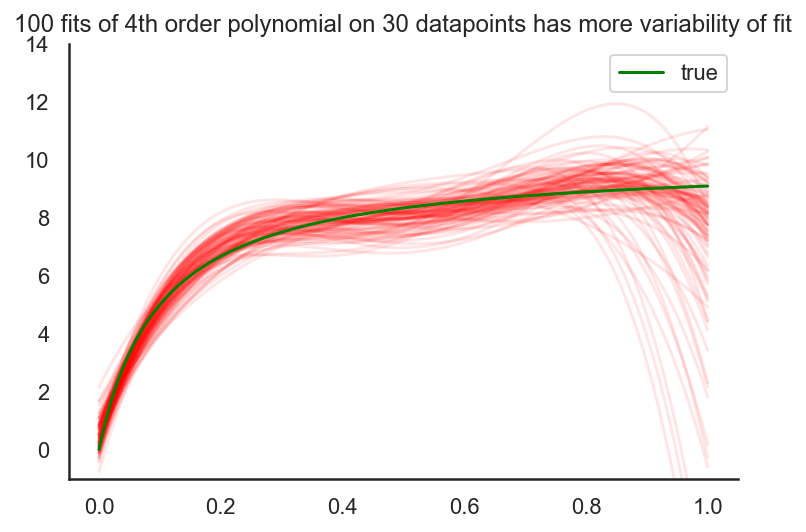

In [ ]:
# draw 3000 data points from the same process
# split them up into 100 random subsets of 30 each
# fit a line on each of those subsets
# plot each of those lines

X, y = make_data(3000)
splitter = KFold(n_splits=100)
degree = 4

x_true = np.linspace(0, 1, 100).reshape(-1, 1) #  some x-vals so we can generate true y-vals
y_true = true_func(x_true)

for _, subset in splitter.split(X,y):
    y_predict = PolynomialRegression(degree,fit_intercept=False).fit(X[subset], y[subset]).predict(x_true)
    plt.plot(x_true.ravel(), y_predict, alpha = 0.1, color='red')

plt.plot(x_true, y_true, label='true', color='green')
plt.ylim(-1, 14)
plt.legend()
plt.title('100 fits of 4th order polynomial on 30 datapoints has more variability of fit');
sns.despine()
    

And that above is an example of the bias-variance tradeoff in cross-validation... more folds is less bias (fit the noise in the dataset) and more variance (new datasets have wider variability in the parameters of fit)

So there is a tradeoff... we generally pick low k values as a rule of thumb... things like k=3, 5, or 10. We know they may systematically overestimated the true error (bias) but it is a small one.  We certainly know that LOOCV (when k= number of data points) is so variable that we are overfitting the noise in the dataset and therefore probably UNDERESTIMATING the true error.

### an easier way

Are you tired of for loops?  We've written a lot of them already.

Did I hear someone say that sklearn has to have an easier way to cross validate?

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

X, y = make_data(40,rseed=1234)

# turn a metric function into a scorer class
mse_scorer = make_scorer(mean_squared_error)

# do it
cross_val_score(model, X, y, cv=5, scoring=mse_scorer)

array([1.50324488, 0.89605096, 2.33486654, 2.21330628, 0.87844726])

# Visualizing simple hyperparameter searches

Introducing validation curves, a cute way to visualize what varying a hyperparameter will do to the algorithms performance.

This function cross-validates an sklearn estimator (any kind of classifier or regression or pipeline of those things) on the data; but it does this with multiple different hyperparameter settings. Then it plots both the training set and validation set (hold out fold) performance against the parameter values it tried.

So if you pass it 15 parameter settings and 5 fold validation it runs 15x5 validation runs. Then you can calculate and plot the median (or mean or whatever) performance level of the 5 folds per parameter setting.

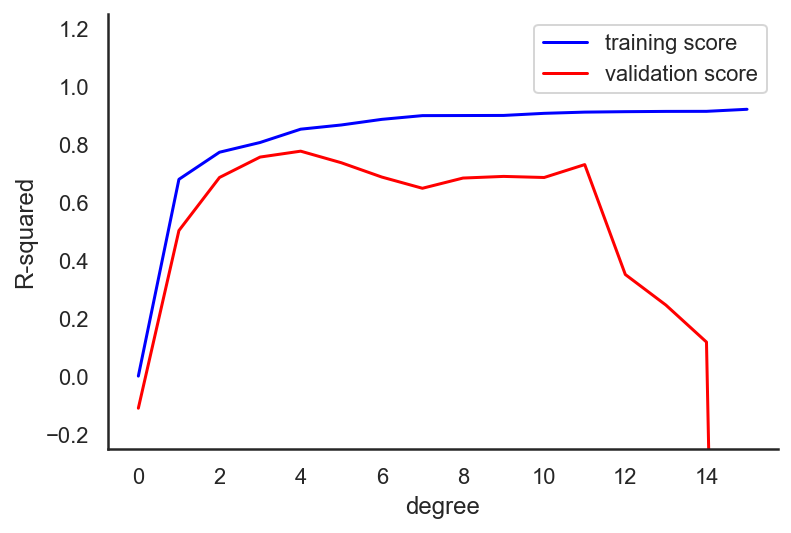

In [ ]:
from sklearn.model_selection import validation_curve

degree = np.arange(0, 16)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                             param_name='polynomialfeatures__degree', 
                                             param_range = degree, # what parameters to iterate over
                                             cv=5, # number of validation folds, can also put in a KFold or StratifiedKFold object here
                                             scoring = 'r2' # uses R-squared... 1 is perfect, below 0 is worse than guessing mean of training set y-values
                                         )

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(-.25, 1.25)
plt.xlabel('degree')
plt.ylabel('R-squared');
sns.despine()

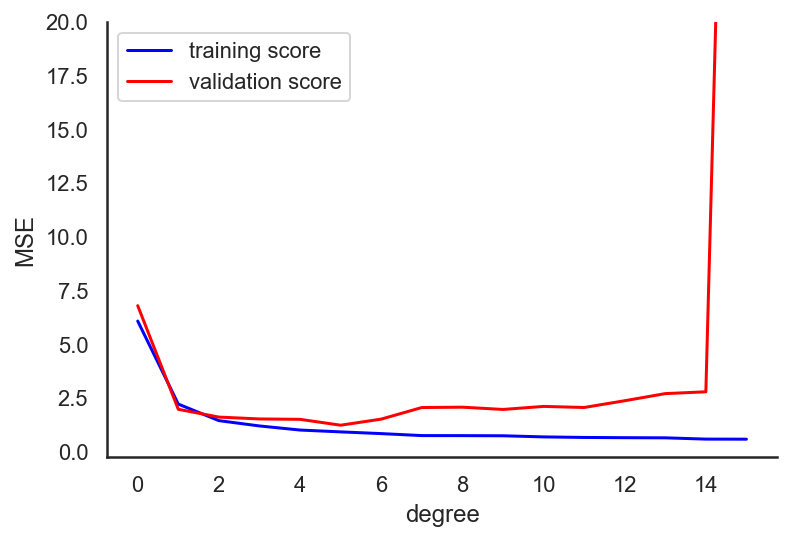

In [ ]:
# Mean squared error version of above

from sklearn.model_selection import validation_curve

degree = np.arange(0, 16)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                             param_name='polynomialfeatures__degree', 
                                             param_range = degree, # what parameters to iterate over
                                             cv=5, # number of validation folds, can also put in a KFold or StratifiedKFold object here
                                             scoring = mse_scorer # Mean squared error version of above
                                         )

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(-0.25, 20)
plt.xlabel('degree')
plt.ylabel('MSE');
sns.despine()

Hey! that's cool.  

We can use one command (plus some other stuff) to see how starting simple and increasing model complexity  starts with underfitting, then becomes well-fitting, then becomes overfitting. 

Isn't iteresting how looking at MSE and R-squared suggest different answers to where a model is well-fit vs overfit?

Let's use the same trick to see how our cross-validation scheme changes our estimates of the validation score



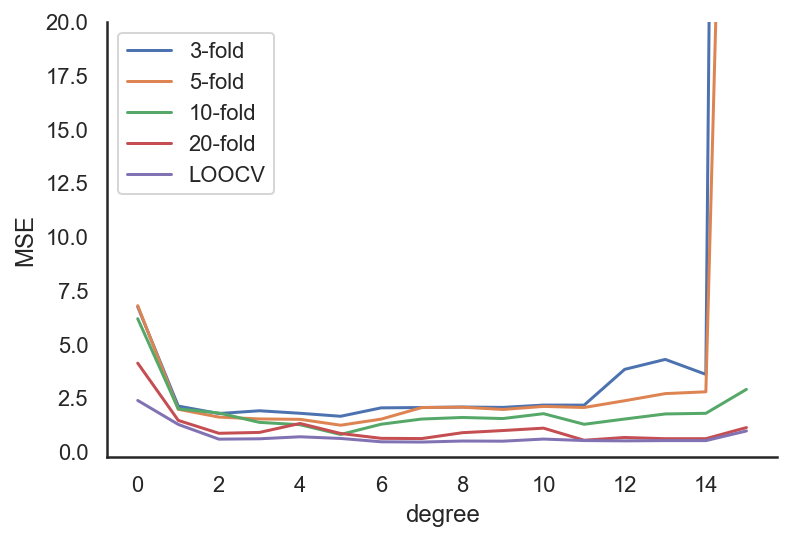

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.metrics import r2_score
from sklearn.model_selection import LeaveOneOut

degree = np.arange(0, 16)
_, val_score_3 = validation_curve(PolynomialRegression(), X, y,
                                             param_name='polynomialfeatures__degree', 
                                             param_range = degree, # what parameters to iterate over
                                             cv=3, # number of validation folds, can also put in a KFold or StratifiedKFold object here
                                             scoring = 'neg_mean_squared_error' # Mean squared error version of above
                                         )

_, val_score_5 = validation_curve(PolynomialRegression(), X, y,
                                             param_name='polynomialfeatures__degree', 
                                             param_range = degree, # what parameters to iterate over
                                             cv=5, # number of validation folds, can also put in a KFold or StratifiedKFold object here
                                             scoring = 'neg_mean_squared_error' # Mean squared error version of above
                                         )

_, val_score_10 = validation_curve(PolynomialRegression(), X, y,
                                             param_name='polynomialfeatures__degree', 
                                             param_range = degree, # what parameters to iterate over
                                             cv=10, # number of validation folds, can also put in a KFold or StratifiedKFold object here
                                             scoring = 'neg_mean_squared_error' # Mean squared error version of above
                                         )

_, val_score_20 = validation_curve(PolynomialRegression(), X, y,
                                             param_name='polynomialfeatures__degree', 
                                             param_range = degree, # what parameters to iterate over
                                             cv=20, # number of validation folds, can also put in a KFold or StratifiedKFold object here
                                             scoring = 'neg_mean_squared_error' # Mean squared error version of above
                                         )

_, val_score_loocv = validation_curve(PolynomialRegression(), X, y,
                                             param_name='polynomialfeatures__degree', 
                                             param_range = degree, # what parameters to iterate over
                                             cv=LeaveOneOut(),  # LOOCV
                                             scoring = 'neg_mean_squared_error' # Mean squared error version of above
                                         )


plt.plot(degree, np.median(-val_score_3, 1),  label='3-fold')
plt.plot(degree, np.median(-val_score_5, 1), label='5-fold')
plt.plot(degree, np.median(-val_score_10, 1),  label='10-fold')
plt.plot(degree, np.median(-val_score_20, 1),  label='20-fold')
plt.plot(degree, np.median(-val_score_loocv, 1),  label='LOOCV')


plt.legend(loc='best')
plt.ylim(-.25, 20)
plt.xlabel('degree')
plt.ylabel('MSE');
sns.despine()

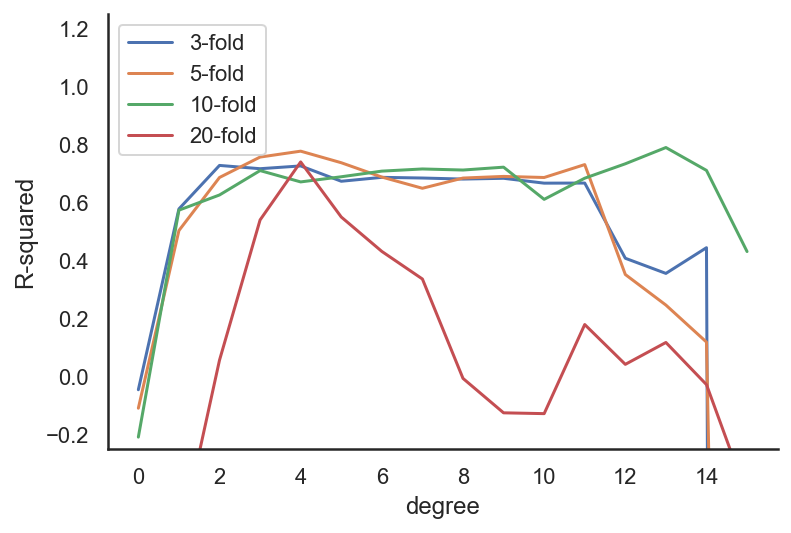

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.metrics import r2_score
from sklearn.model_selection import LeaveOneOut

degree = np.arange(0, 16)
_, val_score_3 = validation_curve(PolynomialRegression(), X, y,
                                             param_name='polynomialfeatures__degree', 
                                             param_range = degree, # what parameters to iterate over
                                             cv=3, # number of validation folds, can also put in a KFold or StratifiedKFold object here
                                             scoring = 'r2' # Mean squared error version of above
                                         )

_, val_score_5 = validation_curve(PolynomialRegression(), X, y,
                                             param_name='polynomialfeatures__degree', 
                                             param_range = degree, # what parameters to iterate over
                                             cv=5, # number of validation folds, can also put in a KFold or StratifiedKFold object here
                                             scoring = 'r2' # Mean squared error version of above
                                         )

_, val_score_10 = validation_curve(PolynomialRegression(), X, y,
                                             param_name='polynomialfeatures__degree', 
                                             param_range = degree, # what parameters to iterate over
                                             cv=10, # number of validation folds, can also put in a KFold or StratifiedKFold object here
                                             scoring = 'r2' # Mean squared error version of above
                                         )

_, val_score_20 = validation_curve(PolynomialRegression(), X, y,
                                             param_name='polynomialfeatures__degree', 
                                             param_range = degree, # what parameters to iterate over
                                             cv=20, # number of validation folds, can also put in a KFold or StratifiedKFold object here
                                             scoring = 'r2' # Mean squared error version of above
                                         )

'''
can't do LOOCV because R2 needs > 2 samples in test set

_, val_score_loocv = validation_curve(PolynomialRegression(), X, y,
                                             param_name='polynomialfeatures__degree', 
                                             param_range = degree, # what parameters to iterate over
                                             cv=LeaveOneOut(),  # LOOCV
                                             scoring = 'r2' # Mean squared error version of above
                                         )
'''

plt.plot(degree, np.median(val_score_3, 1),  label='3-fold')
plt.plot(degree, np.median(val_score_5, 1), label='5-fold')
plt.plot(degree, np.median(val_score_10, 1),  label='10-fold')
plt.plot(degree, np.median(val_score_20, 1),  label='20-fold')
#plt.plot(degree, np.median(-val_score_loocv, 1),  label='LOOCV')


plt.legend(loc='best')
plt.ylim(-.25, 1.25)
plt.xlabel('degree')
plt.ylabel('R-squared');
sns.despine()

Some very interesting results above... we can show how different CV strategies give you a differnet picture of what the best model degree could be.  Also it seems to be related to CV and metric, as R-squared and MSE give very different pictures with the same cross validation strategy.


### Cross-validation:  The bias - variance tradeoff

The changes in results with CV are due to the bias variance tradeoff affecting model selection. 

- LOOCV and k-fold CV lead to _estimates_ of the test error. Any statistical estimate is subject to bias-variance tradeoff.
- LOOCV has almost no bias because it uses almost all the dataset to train, k-fold CV has small bias because you use less of the data to train. 
- But, LOOCV has higher variance with respect to the training set.  That is a different training sample drawn from teh same population will give a different estimate.  This happens because all LOOCV estimates share almost exactly the same training set (-1 sample) and therefore the performance estimate obtained may be overly optimistic when new data is run through the trained model... that new data will have different noise than the training data.
- In contrast the smaller training sets of k-fold yield more variability in each fold's training, which when we average across those folds yields reduced variance in the estimate with respect to the particular noise in the training set.
- This means that a good rule of thumb is to rely on k-folds with small values such as k=5 or k=10 if you don't have a better reason to do otherwise.  This choice represents a usually-pretty-good point in the bias - variance tradeoff.  
- TBH I have no idea why some metrics seem more sensitive to the high variance of high k.  I'd love to know if some of you find it in your reading :)

### Pop quiz:

1. What parameter setting above do you expect to have the best generalization to new data?

1. What parameter setting has the best training set performance? 

1. If the best training set performance setting isn't the best generalizer, why is that?

1. What kinds of CV do you think you should use to evaluate "best model"?  Would your answer to what is the best CV change depending on the dataset, the problem, or the model? 

1. What other scoring options are available in sklearn? What happens if you leave the scoring parameter blank? Is the default scoring method different for different scikit-learn algorithms?

Answers to the last question can be found hidden cleverly in 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html?highlight=validation%20curve#sklearn.model_selection.validation_curve


https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

Bonus method to give you a sense of the range across the validation folds, instead of just plotting the central tendancy as above:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py



# Learning curves
Now sometimes you might be interested in knowing "how many data samples do I need to make a decent classifier?" The answer to this question is dependant on many things, including the algorithm, its hyperparameters, and the data.

So as you might imagine, if you want to fit a more complicated overfitting-prone model, you would find poor generalization performance if you don't have enough data.  Random chance will give you overfitting wiggles since it's a high variance model.  But if you use more data, then things can still come out OK as the model gets enough info to restrict its wiggling.

Let's introduce learning_curve() helper function to find out how polynomial degree affects our data sample needs. It will run each fold of the cross-validation on different random subsamples of the total training data. The reported value is the median across folds at that particular subsample size.

Thus we have an estimate of how much training data we need for simple D=2 vs complex D=9 models

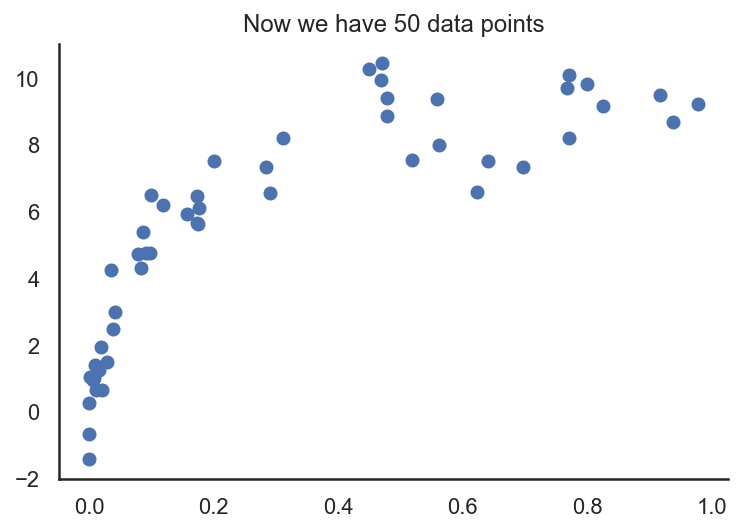

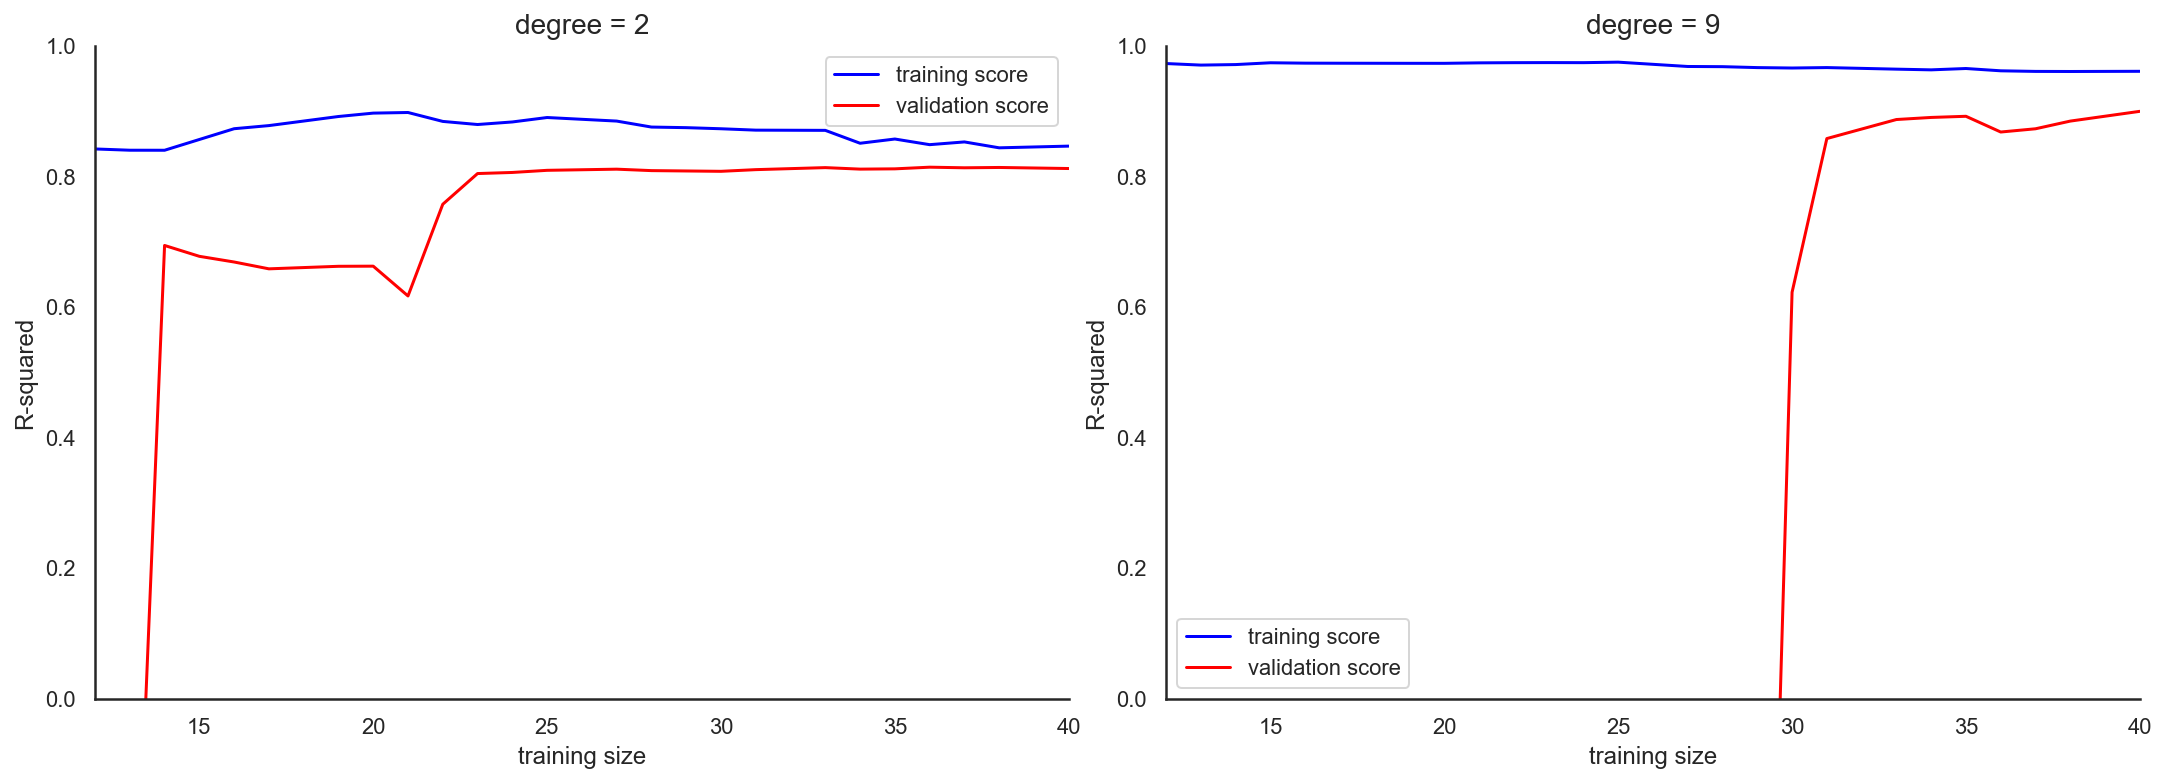

In [ ]:
from sklearn.model_selection import learning_curve

#MOAR data, bigger data
X2, y2 = make_data(50)
plt.scatter(X2.ravel(), y2);
plt.title('Now we have 50 data points')
sns.despine()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X2, y2, cv=5,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('R-squared')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')
    sns.despine()

Sit and think about this for a minute.  

How does a learning curve (performance vs number of data samples) relate to our choice of cross-validation for a given problem?




# Stratification

One possible complication that can occur when your have imbalanced classification problems:

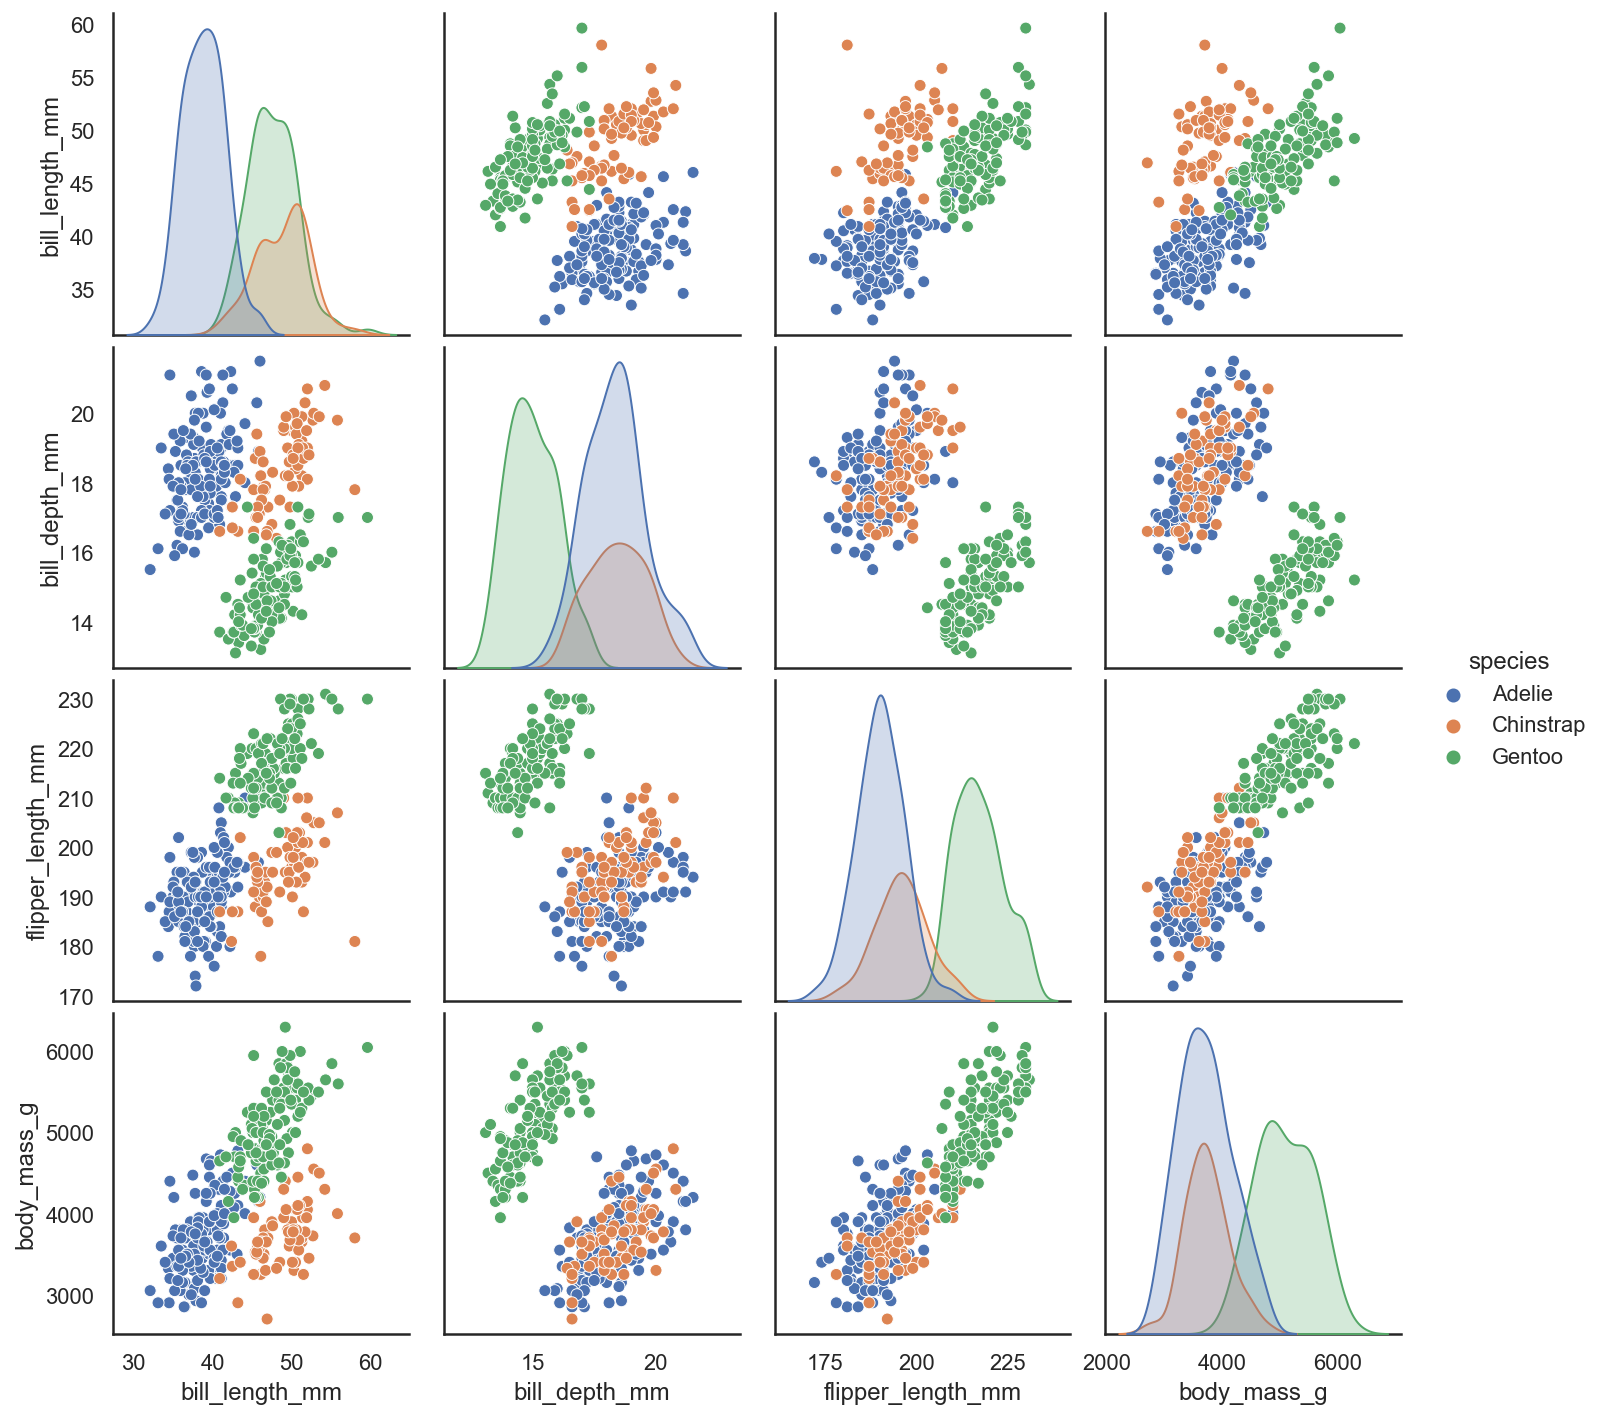

In [ ]:
import seaborn as sns

# lets get some 🐧 data to work with
df = sns.load_dataset('penguins').dropna()
           
sns.pairplot(df,hue='species');

In [ ]:
# fairly few chinstraps!
df['species'].value_counts()

Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64

As you randomly shuffle data for making the folds of the cross-validation, you can end up with folds that under- or over- represent a given class as compared to the training data.  Imagine,that randomly a fold ends up with only 5% of the samples being Chinstrap penguins, and all of those are female. In that case this classifier might be terrible at recognizing Chinstraps in general and males in particular.  So the estimate of generalization performance is now going to be much worse than it might otherwise be.

To address problems like this we can force the folds to have the SAME % of each class as the overall training data using StratifiedKFold as shown below:


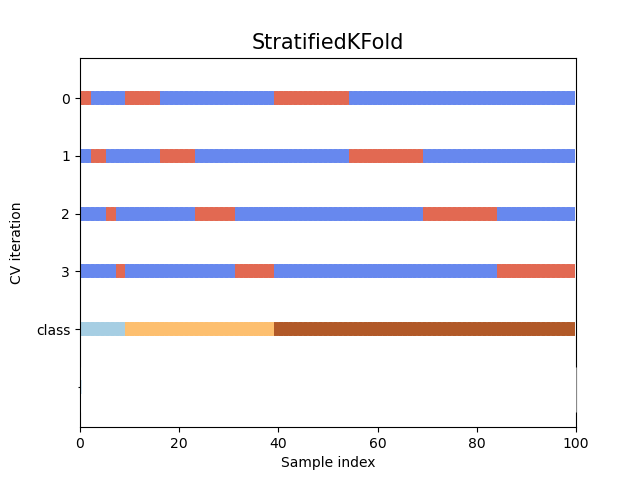

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression 

y_p = df['species'] # predict species from the measurements
X_p = df.drop(columns=['sex','species','island']) # get rid of categorical variables and the label
   
    
results1 = cross_val_score( LogisticRegression(max_iter=5000, random_state=21, penalty='none'), 
                           X_p, y_p, cv=KFold(n_splits=10, random_state=747, shuffle=True))
results2 = cross_val_score( LogisticRegression(max_iter=5000, random_state=21, penalty='none'), 
                           X_p, y_p, cv=StratifiedKFold(n_splits=10, random_state=747, shuffle=True))

results = pd.DataFrame({'Regular': results1, 'Stratified': results2})
results

,Regular,Stratified
0,1.000000,1.000000
1,1.000000,0.970588
2,0.970588,1.000000
3,1.000000,1.000000
4,1.000000,0.909091
5,0.909091,0.969697
6,1.000000,0.969697
7,1.000000,1.000000
8,0.909091,1.000000
9,1.000000,1.000000


In [ ]:
results.describe()

,Regular,Stratified
count,10.000000,10.000000
mean,0.978877,0.981907
std,0.037907,0.029236
min,0.909091,0.909091
25%,0.977941,0.969920
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


Stratified CV reduces the variability between 
folds!  You will likely see a difference in performance mean/median as well. 

So, if we assume that our dataset is a REPRESENTATIVE SAMPLE of the true population, then we should use the Stratified K-fold to get the best estimate of generalization performance.   

Pop quiz: What if the class imbalance doesn't truly reflect the population, it's just an artifact of the dataset? What should we do if we do know the real class balance? E.g. our population is people in the US and we know it's pretty close to 50/50 sex ratio... but our data is 65% male. What can we do to alleviate this problem? 

